In [648]:
"""
Created on Mon Mar 25 18:00:45 2019

@author: luisgranados
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

house_source_data = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")


# Store the label for the training set. 
house_labels = house_source_data['SalePrice'].copy()

# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Stage the ratings for the mapper function.
# Remember, these are ordinal features.
qual_rating_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                'GarageCond', 'PoolQC']

qual_ordinal_ratings = [
        ('Ex',5), 
        ('Gd',4), 
        ('TA',3), 
        ('Fa',2), 
        ('Po',1), 
        ('NA',0)
    ]

# Exposure features need own mapping.
exposure_rating_feature = ['BsmtExposure']
exposure_ordinal_ratings = [
        ('Gd',4), 
        ('Av',3), 
        ('Mn',2), 
        ('No',1), 
        ('NA',0)
    ]

electrical_rating_feature = ['Electrical']
electrical_ordinal_ratings = [
        ('SBrkr',5),
        ('FuseA',4),
        ('FuseF',3),
        ('FuseP',2),
        ('Mix',1)
    ]

functional_rating_feature = ['Functional']
functional_ordinal_ratings = [
        ('Typ',7), 
        ('Min1',6), 
        ('Min2',5), 
        ('Mod',4), 
        ('Maj1',3),
        ('Maj2',2),
        ('Sev',1),
        ('Sal',0)
    ]

# Finish ratings
bsmt_finish_rating_features = ['BsmtFinType1', 'BsmtFinType2']
bsmtfin_ordinal_ratings = [
        ('GLQ',6), 
        ('ALQ',5), 
        ('BLQ',4), 
        ('Rec',3), 
        ('LwQ',2),
        ('Unf',1),
        ('NA',0)
    ]

grg_finish_rating_feature = ['GarageFinish']
grgfin_ordinal_ratings = [
        ('Fin',3), 
        ('RFn',2), 
        ('Unf',1), 
        ('NA',0)
    ]

paved_rating_feature = ['PavedDrive']
paved_ordinal_ratings = [
        ('Y',2), 
        ('P',1), 
        ('N',0)
    ]

fence_rating_feature = ['Fence']
fence_ordinal_ratings = [
        ('GdPrv',4),
        ('MnPrv',3),
        ('GdWo',2), 
        ('MnWw',1),
        ('NA',0)
    ]

alley_rating_feature = ['Alley']
alley_ordinal_ratings = [
        ('Pave',2),
        ('Grvl',1),
        ('NA',0)
    ]

utilities_rating_feature = ['Utilities']
utilities_ordinal_ratings = [
        ('AllPub',3),
        ('NoSewr',2),
        ('NoSeWa',1),
        ('ELO', 0)
    ]

# Select categorical features to one-hot-encode.
categorial_onehot_features = ['MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'GarageType',
    'SaleType',
    'SaleCondition'
    ]

selected_categorical_onehot = [
      
]

# Use this function for generating new ones. I can't generalize this part 
# because of all the potentially different ways to create each feature.
# but this will allow me to do the same generation for the test set.
def generator(dataframe):
    """Generate new features."""
    new_dataframe = dataframe.copy()
    
    #new_dataframe['LotArea_sqrd'] = new_dataframe['LotArea']**2
    
    new_dataframe['yard_size'] = new_dataframe['LotArea'] - (new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    new_dataframe['yard_size_sqrd'] = new_dataframe['yard_size']**2
    
    new_dataframe['yard_size_cubed'] = new_dataframe['yard_size']**3
    
    new_dataframe['YearBuilt_sqrd'] = new_dataframe['YearBuilt']**2
    
    new_dataframe['YearBuilt_cubed'] = new_dataframe['YearBuilt']**3
    
    new_dataframe['total_sqft'] = (new_dataframe['2ndFlrSF'] + new_dataframe['TotalBsmtSF'] + 
                                   new_dataframe['1stFlrSF'] + new_dataframe['GarageArea'])
    
    #new_dataframe['total_sqft_sqrd'] = new_dataframe['total_sqft']**2
    
    #new_dataframe['total_sqft_cubed'] = new_dataframe['total_sqft']**3
    
    new_dataframe['liv_area_interaction'] = new_dataframe['GrLivArea'] * new_dataframe['total_sqft']
    
    new_dataframe['liv_area_interaction_sqrd'] = new_dataframe['liv_area_interaction']**2
    
    #new_dataframe['liv_area_interaction_cubed'] = new_dataframe['liv_area_interaction']**3
    
    new_dataframe['housesqft_qual_inter'] = new_dataframe['total_sqft'] * new_dataframe['OverallQual']
    
    new_dataframe['OverallCond_Qual_inter'] = new_dataframe['OverallCond'] * new_dataframe['OverallQual']
    
    new_dataframe['Garage_sqft_sqrd'] = new_dataframe['GarageArea']**2
    
    #new_dataframe['Garage_sqft_cubed'] = new_dataframe['GarageArea']**3
    
    new_dataframe['Garage_CQ_inter'] = (new_dataframe['GarageQual'] * new_dataframe['GarageCond'] *
                                       new_dataframe['GarageCars'] * new_dataframe['GarageArea'])
    
    #new_dataframe['Outdoor_lounging'] = (new_dataframe['EnclosedPorch'] + new_dataframe['OpenPorchSF'] * 
    #                                     new_dataframe['WoodDeckSF'] + new_dataframe['3SsnPorch'] +
    #                                     new_dataframe['ScreenPorch'])
    
    #new_dataframe['Outdoor_lounging_sqrd'] = new_dataframe['Outdoor_lounging']**2
    
    #new_dataframe['Outdoor_lounging_cubed'] = new_dataframe['Outdoor_lounging']**3
    
    #new_dataframe['outdoor_inter'] = new_dataframe['Outdoor_lounging'] * new_dataframe['yard_size']
    
    #new_dataframe['RoomQual_inter'] = new_dataframe['TotRmsAbvGrd'] * new_dataframe['OverallQual']
    
    #new_dataframe['BedroomAbvGr_sqrd'] = new_dataframe['BedroomAbvGr']**2
    
    #new_dataframe['BedroomAbvGr_cubed'] = new_dataframe['BedroomAbvGr']**3
    
    new_dataframe['Exter_inter'] = new_dataframe['ExterCond'] * new_dataframe['ExterQual'] * new_dataframe['MasVnrArea']
 
    new_dataframe['KitchenAbvGr_sqrd'] = new_dataframe['KitchenAbvGr']**2
    
    #new_dataframe['kitchen_inter'] = new_dataframe['KitchenAbvGr'] * new_dataframe['KitchenQual']
    
    new_dataframe['bsmt_qual_inter'] = (new_dataframe['BsmtQual'] * new_dataframe['BsmtCond'] * 
                                        new_dataframe['TotalBsmtSF'])

    new_dataframe['BsmtQual_sqrd'] = new_dataframe['BsmtQual']**2
    
    new_dataframe['BsmtQual_cubed'] = new_dataframe['BsmtQual']**3
    
    new_dataframe['BsmtUnfSF_sqrd'] = new_dataframe['BsmtUnfSF']**2
    
    new_dataframe['BsmtUnfSF_cubed'] = new_dataframe['BsmtUnfSF']**3
    
    new_dataframe['BsmtFinSF2_sqrd'] = new_dataframe['BsmtFinSF2']**2
    
    new_dataframe['BsmtFinSF2_cubed'] = new_dataframe['BsmtFinSF2']**3
    
    #new_dataframe['bath_inter'] = (new_dataframe['OverallCond'] * new_dataframe['FullBath'] *
    #                              new_dataframe['OverallQual'])
    
    new_dataframe['fireplace_inter'] = new_dataframe['Fireplaces'] * new_dataframe['FireplaceQu']
    
    return new_dataframe

def mapper(data_in, features, ratings):
    """Map ordinal ratings to numeric ranking."""
    counter = 0
    for feature in features:
        ordinal_mapping = [{
            "col":feature,    
            "mapping": ratings},
        ]

        encoder = ce.OrdinalEncoder(mapping = ordinal_mapping, 
                                    return_df = True, cols = feature)
        if counter == 0:
            df_train = encoder.fit_transform(data_in.copy())
        else:
            df_train = encoder.fit_transform(df_train)
        counter += 1
    return df_train

def data_staging(data_in):
    """Create preliminary training set."""
    data_frame = data_in.copy()
    
    # Fill in the null values with None.
    category_data = data_frame.copy().select_dtypes(exclude='number').fillna(value='None')

    # Fill in null values with 0.
    numeric_data = (data_frame
             .loc[:, data_frame.copy().columns != 'LotFrontage']
             .select_dtypes(include='number')
             .fillna(value=0)
            )

    # Re-merge the two datasets. Drop label and unneeded features.
    data_in_cleaned = (category_data
                         .merge(numeric_data, how='outer',
                                left_index=True, right_index=True)
                         .drop(columns=['SalePrice', 'MiscFeature', 'Id'], errors='ignore')
                        )
    data_in_cleaned = pd.concat([data_in_cleaned, data_in['LotFrontage']], axis=1)
    
    data_in_cleaned = mapper(data_in_cleaned, qual_rating_features, qual_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, bsmt_finish_rating_features, bsmtfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, exposure_rating_feature, exposure_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, electrical_rating_feature, electrical_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, functional_rating_feature, functional_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, grg_finish_rating_feature, grgfin_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, paved_rating_feature, paved_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, fence_rating_feature, fence_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, alley_rating_feature, alley_ordinal_ratings)
    data_in_cleaned = mapper(data_in_cleaned, utilities_rating_feature, utilities_ordinal_ratings)
    
    # Generate new features.
    data_in_cleaned = generator(data_in_cleaned)
    
    return data_in_cleaned

# Create the preliminary training set. This is for analysis.
# numeric attributes get pulled from here.

features_to_drop = ['MoSold', 'YrSold', 'BsmtFinType2', '3SsnPorch', 'BsmtFinSF2',
                   'BsmtHalfBath', 'PoolArea', 'ExterCond', 'Utilities', 'MiscVal',
                   'LowQualFinSF', 'OverallCond', 'Alley', 'EnclosedPorch',
                   'KitchenAbvGr', 'Fence', 'Functional', 'ScreenPorch', 'PoolQC',
                   'BedroomAbvGr', 'BsmtCond', 'Electrical',
                   'GarageYrBlt']

house_train_staging = data_staging(house_source_data.copy()).drop(columns=features_to_drop)
house_test_staging = data_staging(house_test.copy()).drop(columns=features_to_drop)

# Store all the numeric type column names for DataFrameSelector(). 
# MSSubClass gets encoded, so it gets droped from the numeric list of features to process.
numeric_features = list(house_train_staging.select_dtypes(include='number').columns)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), categorial_onehot_features)
    ])

house_train = preprocessor.fit_transform(house_train_staging.copy())
house_test_data = preprocessor.transform(house_test_staging.copy())

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

seed = 42
np.random.seed(seed)

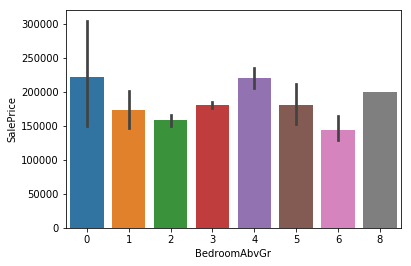

In [647]:
sns.barplot(house_source_data['BedroomAbvGr'], house_source_data['SalePrice'])

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [94]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE).
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [649]:
lasso_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('lasso', Lasso(selection='random', random_state=np.random.seed(seed)))])

lasso_param_grid = {'lasso__alpha' : [10, 50, 100, 300, 400, 500, 600, 700, 800, 1000, 10000]}

lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=5, n_jobs=-1)

lasso_grid.fit(house_train_staging.copy(), house_labels)

lasso_grid_pred = lasso_grid.best_estimator_.named_steps['lasso'].predict(house_train)

#lasso_rmse = rmsle(house_labels, lasso_grid_pred)

lasso_grid_best = lasso_grid.best_estimator_.named_steps['lasso']

print('Results: {:8f} '.format(lasso_grid.best_score_))

Results: 0.886814 


/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [628]:
print('Results: {:8f} '.format(lasso_grid.best_score_))

Results: 0.886821 


In [629]:
lasso_grid.best_params_

{'lasso__alpha': 100}

In [630]:
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('rig', Ridge(random_state=np.random.seed(seed)))])

ridge_param_grid = {'rig__alpha' : [0.5, 1, 5, 10, 15, 20, 50, 100, 1000]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_grid, cv=5, n_jobs=-1)

ridge_grid.fit(house_train_staging.copy(), house_labels)

ridge_grid_pred = ridge_grid.best_estimator_.named_steps['rig'].predict(house_train)

ridge_grid_best = ridge_grid.best_estimator_.named_steps['rig']

print('Results: {:8f}'.format(ridge_grid.best_score_))

Results: 0.886184


In [631]:
ridge_grid.best_params_

{'rig__alpha': 15}

In [633]:
from sklearn.svm import SVR

svm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('svm', SVR(gamma='scale'))])

svm_param_grid =  {'svm__C' : [ 400000, 470000, 480000, 490000, 500000, 510000],
                   'svm__epsilon' : [2000, 3000, 4000, 5000, 6000]}

svm_grid = GridSearchCV(svm_pipe, param_grid=svm_param_grid, cv=5, n_jobs=-1)

svm_grid.fit(house_train_staging.copy(), house_labels)

svm_grid_pred = svm_grid.best_estimator_.named_steps['svm'].predict(house_train)

svm_rmse = rmsle(house_labels, svm_grid_pred)

svm_grid_best = svm_grid.best_estimator_.named_steps['svm']

print('Results: {:8f} {:8f}'.format(svm_grid.best_score_, svm_rmse))

Results: 0.873621 0.044876


In [634]:
print('Results: {:8f} {:8f}'.format(svm_grid.best_score_, svm_rmse))

Results: 0.873621 0.044876


In [635]:
svm_grid.best_params_

{'svm__C': 490000, 'svm__epsilon': 6000}

In [636]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('rf', RandomForestRegressor(random_state=np.random.seed(seed), n_jobs=-1))])

rf_param_grid =  {'rf__max_depth' : [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
                   'rf__n_estimators' : [100, 200, 300, 600],
                   'rf__max_features': ['sqrt']}

rf_grid = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)

rf_grid.fit(house_train_staging.copy(), house_labels)

rf_grid_pred = rf_grid.best_estimator_.named_steps['rf'].predict(house_train)

rf_grid_best = rf_grid.best_estimator_.named_steps['rf']

print('Results: {:8f}'.format(rf_grid.best_score_))

Results: 0.877371


In [502]:
print('Results: {:8f}'.format(rf_grid.best_score_))

Results: 0.879116


In [637]:
rf_grid.best_params_

{'rf__max_depth': 37, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}

In [ ]:
print('Results: {:8f} {:8f}'.format(rf_grid.best_score_, rf_rmse))

In [638]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gbr', GradientBoostingRegressor(random_state=np.random.seed(seed)))])

gbr_param_grid = {'gbr__max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'gbr__n_estimators' : [40, 50, 80, 90],
                  'gbr__learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
                  'gbr__subsample' : [0.1, 0.6, 0.9, 1.0]}

gbr_grid = GridSearchCV(gbr_pipe, param_grid=gbr_param_grid, cv=5, n_jobs=-1)

gbr_grid.fit(house_train_staging.copy(), house_labels)

gbr_grid_pred = gbr_grid.best_estimator_.named_steps['gbr'].predict(house_train)

gbr_grid_best = gbr_grid.best_estimator_.named_steps['gbr']

print('Results: {:8f}'.format(gbr_grid.best_score_))

/anaconda3/envs/Kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Results: 0.896426


In [639]:
gbr_grid.best_params_

{'gbr__learning_rate': 0.2,
 'gbr__max_depth': 6,
 'gbr__n_estimators': 50,
 'gbr__subsample': 0.6}

In [ ]:
encoded_features = OneHotEncoder(handle_unknown='ignore').fit(house_train_staging[selected_categorical_onehot]).get_feature_names()

all_features = numeric_features + list(encoded_features)

print(len(all_features))

In [ ]:
['OverallCond', 'MasVnrArea','BsmtFinSF2', 'LowQualFinSF',
 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 
 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'ExterQual', 'ExterCond', 'BsmtQual',
 'BsmtCond', 'HeatingQC', 'KitchenQual', 'Alley', 'BsmtExposure', 'BsmtFinType1',
 'BsmtFinType2', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive',
 'PoolQC', 'Fence', 'Utilities', 'MSSubClass', 'EnclosedPorch']

In [250]:
# Get all the feature importances
importances = list(rf_grid_best.feature_importances_)
encoded_features = OneHotEncoder(handle_unknown='ignore').fit(house_train_staging[categorial_onehot_features]).get_feature_names()

all_features = numeric_features + list(encoded_features)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(all_features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: housesqft_qual_inter_sqrd Importance: 0.08
Variable: housesqft_qual_inter_cubed Importance: 0.08
Variable: housesqft_qual_inter Importance: 0.07
Variable: total_sqft_sqrd      Importance: 0.06
Variable: total_sqft           Importance: 0.05
Variable: total_sqft_cubed     Importance: 0.05
Variable: liv_area_interaction Importance: 0.05
Variable: OverallQual          Importance: 0.04
Variable: liv_area_interaction_sqrd Importance: 0.04
Variable: RoomQual_inter       Importance: 0.04
Variable: GrLivArea            Importance: 0.03
Variable: Garage_CQ_inter      Importance: 0.03
Variable: bsmt_qual_inter      Importance: 0.03
Variable: bath_inter           Importance: 0.03
Variable: ExterQual            Importance: 0.02
Variable: BsmtQual             Importance: 0.02
Variable: YearBuilt            Importance: 0.02
Variable: TotalBsmtSF          Importance: 0.02
Variable: GarageCars           Importance: 0.02
Variable: GarageArea           Importance: 0.02
Variable: KitchenQual   

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_logarithmic_error

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=np.shape(house_train)[1], kernel_initializer='normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset

nn_estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=128, verbose=1)

nn_estimator.fit(house_train, house_labels)

results = cross_val_score(nn_estimator, house_train, house_labels, cv=5, n_jobs =1)
score = nn_estimator.score(house_train, house_labels)
rmse = rmsle(house_labels, nn_estimator.predict(house_train))

print("Results: {:.2f}% ({:.2f}%) {:.5f} {:.5f}".format(results.mean()*100, results.std()*100, score, rmse))

In [158]:
def kaggle_submission(estimator, test_set, test_source, label, kaggle_id):
    """
    Create a csv to submit predictions to Kaggle.
    
    estimator: Sci-kit estimator used on training set.
    test_set: The test set.
    label: The name of the label; must be a string.
    test_source: The original training set, which contains the Id column.
    kaggle_id: The id column from the test set. 
    """
    predictions = estimator.predict(test_set)
    predictions = pd.DataFrame(predictions, columns=[label])
    submission = pd.DataFrame(test_source[kaggle_id])
    submission[label] = predictions[label]
    return submission

predictions = kaggle_submission(gbr_grid_best, house_test_data, 
                                house_test, 'SalePrice', 'Id')

predictions.to_csv('gbr_reduced_with_featuring_submission.csv', index=False)